# Using Naive Bayes to predict 2017 County Data: Casey Surratt

This document covers all of my code which was entirely hand written except for the plotting code which I found and edited.

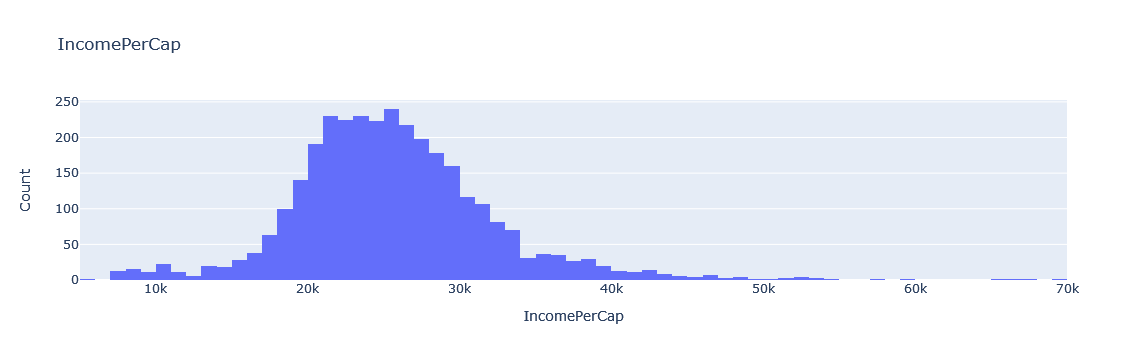

In [91]:
#Casey

# Import statements and some very minor data exploration

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
# sns.set_theme()
og_df = pd.read_csv('archive/acs2017_county_data.csv')
# df.describe()

# plt.hist(og_df['Income'], bins=100)

ystr = "Count"
xstr = "IncomePerCap"

wfh_v_private = px.histogram(og_df, x=xstr, title=xstr).update_layout(yaxis_title=ystr, xaxis_title=xstr)
wfh_v_private
# og_df.columns
# og_df.head()

## Data Cleaning
My first challenge was to make sure I only had data I wanted to use, so I removed the id column and county because they were unique values which would be useless data. I then combined Men and Women into a Men% column (I left out the women% column because it appeared to be binary in the data and so can be infered from men%). Later I discovered that I also needed to drop the pacific column because it was causing double overflow error because they were all so small.

## Data Binning
The second thing I had to do was to bin the features. Because Naive Bayes requires keeping track of every feature value's conditional probability, There must be discrete and  overlaping values for each feature. I decided to simply bin every feature by equal frequency (so 33% of the data in each), evenly dividing every feature's values into 3 parts: Low, Med, High.
I experiment later with binning the label into different sizes but the code which does it is in here. (On a side note, I'm also dropping things directly related to the thing I'm checking so if I'm looking at income, I'm dropping IncomePerCap etc.)

In [2]:
# Casey

# Removes columns from the dataframe and then bins all of the remaining columns into "low" "Med" "High" divided by even frequency
def pruning_and_binning (og_df, labelBins, labels, labelCol):
    
    
    df_pruned = og_df
    df_pruned = df_pruned.drop('CountyId', axis=1)
    df_pruned = df_pruned.drop('County', axis=1) 
    
    df_pruned['MenPercent'] = round(df_pruned['Men'] / df_pruned['TotalPop'], 2)
    # df_pruned['WomenPercent'] = round(df_pruned['Women'] / df_pruned['TotalPop'], 2)
    df_pruned = df_pruned.drop('Men', axis=1)
    df_pruned = df_pruned.drop('Women', axis=1)
    
    df_pruned = df_pruned.drop('Pacific', axis=1)

    if(labelCol == 'Income'):
        df_pruned = df_pruned.drop('IncomePerCap', axis=1)
        df_pruned = df_pruned.drop('IncomePerCapErr', axis=1)
        df_pruned = df_pruned.drop('IncomeErr', axis=1)
    elif(labelCol == 'IncomePerCap'):
        df_pruned = df_pruned.drop('Income', axis=1)
        df_pruned = df_pruned.drop('IncomePerCapErr', axis=1)
        df_pruned = df_pruned.drop('IncomeErr', axis=1)
    
    
    # df_additions.head()
    # df_additions.columns

    # Bin Everything
    df_binned = df_pruned

    # For Specific sized bins
    df_binned[labelCol] = pd.cut(x = df_pruned[labelCol], bins = labelBins, labels = labels, include_lowest = True)

    for i in range(len(df_binned.columns)-1):
        colName = df_binned.columns[i+1]
        if(colName != labelCol):
            feature_labels = ['Low', 'Mid', 'High']
            df_binned[colName], cut_bin = pd.qcut(x = df_pruned[colName], q = 3, labels = feature_labels, retbins = True)
        # print(colName)
        # print(labels)
        # print(cut_bin)
    
    print("Pruned & Binned\n")
    return df_binned
    
# df_binned.head()

## Creating a Train and Test/Validation set
My next task was to divide the data to be able to check my model. I simply selected some percent of the data as the Train set and left the rest as the "Test" set. Since I was using the "Test" set for tuning the model I was planning on treating it like a validation set and actually testing on the 2015 dataset (Although It'd have been different it would have been interesting), however, whoever collected the data changed how they were doing it so I ran out of time to adapt it to fit what I'd written already

In [3]:
#Casey

# Splitting into a train & test set

def get_trainingSet_and_testSet(df_binned, fraction):
    # Gets a fraction as a training set
    df_training = df_binned.sample(frac=fraction, replace=False, axis=0)
    # Takes the rest and returns it as a test set
    df_testSet = df_binned[~df_binned.isin(df_training)].dropna(how = 'all')
    # Shuffle Test Set
    df_testSet = df_testSet.sample(frac=1, replace=False, axis=0)
    print("Split & Shuffled\n")
    return df_training, df_testSet
    

## Building the model
This is where I actually built the model, I input the train set and label column and it outputs two arrays: THe marginal probability of the label values, and a 3d array holding the conditional probability of each feature given the label value. It's mostly just a lot of code that's getting how many times a value shows up with a given label value and normalizes it. It's not the most efficient way to store it but it was how I first approached it.

In [4]:
#Casey

# Building a Baysian model
# Outputs two arrays, The first is the marginal probabilities of all the labels, the
# second is the conditional probability of every feature given each label

def build_naive_bayes_model(df_train, labelCol):
    labelCounts = pd.Series(df_train[labelCol].value_counts())
    labelMarginals = labelCounts / len(df_train)
    labelConditionals = []

    for i in range(len(labelCounts)):
        labelConditionals.append([])
        curLabel = df_train[labelCol].value_counts().index[i]
        df_conditional = df_train[df_train[labelCol] == curLabel]

        for j in range(len(df_conditional.columns)):
            colOfInterest = [df_conditional.columns[j]]

            df1 = df_conditional[colOfInterest].value_counts()
            df1 = df1.astype(float)
            df1 = (df1 + 1) / (labelCounts[i]+1)

    #       Check for values not in the sample and set them to 1/labelCounts
            for k in range(len(df_train[colOfInterest].value_counts())):
                indexVal = df_train[colOfInterest].value_counts().index[k]
                if(indexVal not in df1.index):
                    newDF = pd.Series([1/(labelCounts[i]+1)], [indexVal])
                    df1 = pd.concat([df1, newDF])
            labelConditionals[i].append(df1)

            
    # This line prints the conditionals table for each label, it's cool but got annoying after a lot of runs
    # (Note: despite it containing the probability of the label = 1 if it's the label, that's not used in the predictor)
    # print(labelConditionals)
    
    print("Model Built\n")
    
    return labelMarginals, labelConditionals

## Running the Model
This is where I actually use the probabilities. This takes the entire test set and probabilities and finds the most probable label for each item. It then records the number it gets right of each type and the total number of each type it predicts.

In [5]:
# Casey

# Evaluates the test set with the Bayes Model, outputting the sum of each label's prediction (totalOutput) 
# and the sum of each correct prediction (correctOutput)

def eval_with_bayes_model(df_testSet, labelMarginals, labelConditionals, label, labels):
    print("Running Inference Task\n")

    totalOutput = pd.Series([0]*len(labels), labels)
    correctOutput = pd.Series([0]*len(labels), labels)
    numCorrect = 0

    for k in range(len(df_testSet)):
        df_row = df_testSet.iloc[k]

        labelProbabilities = labelMarginals.copy()

        for i in range(len(labelProbabilities)):
            for j in range(len(df_row)):
                if(df_row.index[j] != label):
                    x = labelConditionals[i][j]
                    # print(x.loc[df_row[j]][0])
                    # print(df_row[j])
                    if df_row[j] in x:
                        labelProbabilities[i] *= x.loc[df_row[j]][0]



        totalOutput.loc[labelProbabilities.idxmax()] += 1
        if(labelProbabilities.idxmax() == df_row.loc[label]):
            numCorrect += 1
            correctOutput.loc[labelProbabilities.idxmax()] += 1

        if(False):
            print("Inference")
            print("Prediction: ")
            print("Actual: ")
            print(df_row[label])
            print(labelProbabilities.idxmax())

    return totalOutput, correctOutput

## Printing
This is just a helper method which outputs the results nicely

In [6]:
# Casey

# Prints some useful information about the results

def printResults(df_testSet, totalOutput, correctOutput, labelCol):
    print("Distribution of TestSet Data:")
    print(df_testSet[labelCol].value_counts())
    print()
    print("Total Output Distribution: ")
    print(totalOutput)
    print()
    print("CorrectOutput Distribution: ")
    print(correctOutput)
    print()
    print("NumCorrect: " + str(correctOutput.sum()))
    print("Accuracy: "  + str(correctOutput.sum() / len(df_testSet)))
    # pres = numCorrect / len(df_testSet)
    # print("Precision: "  + str(pres)
    # rec = 
    # print("Recall: "  + str(rec)

## Putting it all together
This method puts everything together and runs it to an output. It allows the user to input the bins and labels for the labelColumn and the percent of the train set to be used as a validation set (Manual validation).

In [94]:
# Casey

# Uses all the previous functions to create a model from the county data, and evaluate the validation set (test_set)
# Then outputs the results "nicely" formatted, and plots the actual vs expected prediction results

def runNaiveBayes(labelCol, bins, labels, trainSetPerc):

    og_df = pd.read_csv('archive/acs2017_county_data.csv')

    df_binned = pruning_and_binning(og_df, bins, labels, labelCol)

    df_train, df_test = get_trainingSet_and_testSet(df_binned, trainSetPerc)

    label_marg, label_cond = build_naive_bayes_model(df_train, labelCol)

    totalOutput, correctOutput = eval_with_bayes_model(df_test, label_marg, label_cond, labelCol, labels)

    print("Results:")
    print("\nLabel: " + str(labelCol))
    print("Bins: " + str(bins))
    print("Labels: " + str(labels) + "\n")
    # print("\nLabel distribution: ")
    # print(label_marg)

    printResults(df_test, totalOutput, correctOutput, labelCol)
    
    plotBayes(df_test, correctOutput, labelCol)
    
    print(label_cond)
    
    return df_test, totalOutput, correctOutput, labelCol

## Visually displaying it all
This method was found either from stackOverflow or Kaggle, I can't remember which, and I adapted it to display the actual value for each label and the number the model correctly predicted.

In [59]:
# Found from kaggle and adjusted to display my information
def plotBayes(df_test, correctOutput, labelCol):
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True

    labels = df_test[labelCol].value_counts().sort_index().index
    test_set_numbers = df_test[labelCol].value_counts()
    test_set_numbers = test_set_numbers.sort_index()
    output_numbers = correctOutput
    output_number = output_numbers.sort_index()
    # print(labels)
    # print(test_set_numbers)
    # print(output_numbers)

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, test_set_numbers, width, label='Actual')
    rects2 = ax.bar(x + width / 2, output_numbers, width, label='Predicted')

    ax.set_ylabel('Count')
    ax.set_title('Number of ' + labelCol + ' bins correctly predicted')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
       for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
             xy=(rect.get_x() + rect.get_width() / 2, height),
             xytext=(0, 3), # 3 points vertical offset
             textcoords="offset points",
             ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    print(plt.show())

## Ensemble???
The next three boxes were thrown together when trying to add Bayes to the ensemble method but it really didn't work out. They didn't have the information my implementation needed. These are mainly fragments of previous code

In [12]:
# Casey

# Generates a Naive Bayes model using test/train sets as input so that it could be used in an ensemble method

def generateNaiveBayesModel(test_set, train_set, labels, bins, labelCol):
    df_test = pruning_and_binning(test_set, bins, labels, labelCol)
    df_train = pruning_and_binning(train_set, bins, labels, labelCol)

    label_marg, label_cond = build_naive_bayes_model(df_train, labelCol)
    return label_marg, label_cond, df_test

In [9]:
# Casey

# Returns the prediction for any given row, while taking as input "the model" or the marginal/conditional probability arrays, row and label
# To be used with an ensemble method or the like

def predictWithBayes(df_row, labelMarginals, labelConditionals, label):
    labelProbabilities = labelMarginals.copy()

    for i in range(len(labelProbabilities)):
        for j in range(len(df_row)):
            if(df_row.index[j] != label):
                x = labelConditionals[i][j]
                # print(x.loc[df_row[j]][0])
                # print(df_row[j])
                if df_row[j] in x:
                    labelProbabilities[i] *= x.loc[df_row[j]][0]
    return labelProbabilities.idxmax()

In [11]:
# Casey

# Another approach so that it could be combined with another train/test set input
# Mostly just experimenting/ bug fixing

labelCol = 'IncomePerCap'
bins = [0, 25000, math.inf]
labels = ['Low', 'High']

og_df = pd.read_csv('archive/acs2017_county_data.csv')

df_binned = pruning_and_binning(og_df, bins, labels, labelCol)

df_train, df_test = get_trainingSet_and_testSet(df_binned, 0.8)

label_marg, label_cond = build_naive_bayes_model(df_train, labelCol)

predictWithBayes(df_test.iloc[0], label_marg, label_cond, labelCol)

Pruned & Binned

Split & Shuffled

Model Built



'Low'

## Comparing years
This code was meant to be used to train the model on the 2017 data and test on the 2015 but the datasets were too different to be easily compatible and I ran out of time

In [80]:
# Casey

# Basically identical to the runNaiveBayes method except uses the 2017 data as the train set and the 2015 data as the test set
# Doesn't work due to data set limitations :(

def runNaiveBayesNewSet(labelCol, bins, labels):

    og_df = pd.read_csv('archive/acs2017_county_data.csv')
    og15_df = pd.read_csv('archive/acs2015_county_data.csv')

    label_marg, label_cond, df_test = generateNaiveBayesModel(og15_df, og_df, labels, bins, labelCol)

    totalOutput, correctOutput = eval_with_bayes_model(df_test, label_marg, label_cond, labelCol, labels)

    print("Results:")
    print("\nLabel: " + str(labelCol))
    print("Bins: " + str(bins))
    print("Labels: " + str(labels) + "\n")
    # print("\nLabel distribution: ")
    # print(label_marg)

    printResults(df_test, totalOutput, correctOutput, labelCol)
    return df_test, totalOutput, correctOutput, labelCol

## Finally running the things:
This is where I actually ran everything. Most of it is commented it out to save runtime but I uncommented one of each of the lines at a time to see how each did. They're accuracy can be seen on the side. Most of the results are pretty evenly split otherwise. I didn't check recall & precision because when I looked at the results myself the misses were almost uniformly spread across the options so there wasn't one failing. And that's my data Inference exploration.

Pruned & Binned

Split & Shuffled

Model Built

Running Inference Task

Results:

Label: IncomePerCap
Bins: [0, 25000, inf]
Labels: ['Low', 'High']

Distribution of TestSet Data:
High    339
Low     305
Name: IncomePerCap, dtype: int64

Total Output Distribution: 
Low     305
High    339
dtype: int64

CorrectOutput Distribution: 
Low     262
High    296
dtype: int64

NumCorrect: 558
Accuracy: 0.8664596273291926


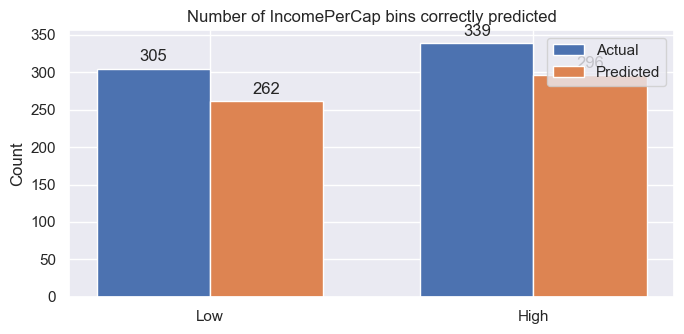

None
[[State               
Texas                   0.074615
Iowa                    0.053077
Minnesota               0.049231
Virginia                0.048462
Nebraska                0.047692
Illinois                0.044615
Kansas                  0.040000
Wisconsin               0.036923
North Dakota            0.033077
Ohio                    0.033077
New York                0.033077
Indiana                 0.032308
Pennsylvania            0.032308
South Dakota            0.031538
Colorado                0.026923
Georgia                 0.024615
Montana                 0.023846
Florida                 0.023077
California              0.022308
Michigan                0.022308
Kentucky                0.020000
North Carolina          0.017692
Washington              0.017692
Missouri                0.016923
Tennessee               0.016154
Oklahoma                0.016154
Alaska                  0.015385
Oregon                  0.015385
New Jersey              0.014615
Maryland       

In [95]:
# Casey

# Where I actually used the methods/ got actual results

# Experimenting with number of bins for the labels & Valication Set

# Trying different size bins, divides lables evenly by frequency across the bins
labelCol = 'IncomePerCap'
# labels = ['Low', 'Low-Med', 'Med', 'High-Med', 'High'] #~52% Accuracy
# labels = ['Low', 'Low-Med','High-Med', 'High'] #~63% Accuracy
# labels = ['Low', 'Med', 'High'] #~74% Accuracy
# labels = ['Low', 'High'] #~87% Accuracy
# df_discard, cut_bin = pd.qcut(x = og_df[labelCol], q = len(labels), labels = labels, retbins = True)
# runNaiveBayes(labelCol, cut_bin, labels, 0.8) 


labels = ['Low', 'High']
# Experimenting with the exact breakpoint to best divide the set
runNaiveBayes(labelCol, [0, 25000, math.inf], labels, 0.8) #87%  ****Seems the best set up****
# runNaiveBayes(labelCol, [0, 30000, math.inf], labels, 0.8) #85%
# runNaiveBayes(labelCol, [0, 20000, math.inf], labels, 0.8) #87%

# Experiments with the best size for the validation set
# runNaiveBayes(labelCol, [0, 25000, math.inf], labels, 0.8) #87%
# runNaiveBayes(labelCol, [0, 25000, math.inf], labels, 0.95) #87%
# runNaiveBayes(labelCol, [0, 25000, math.inf], labels, 0.65) #85%

# I tried to train Naive Bayes on the 2017 set and test on the 2015 set
# This didn't work because the entries in some columns were formatted differently and also somce column names were different (that could be fixed though)
# df_test, totalOutput, correctOutput, labelCol = runNaiveBayesNewSet(labelCol, [0, 25000, math.inf], labels) #N/A